<a href="https://colab.research.google.com/github/shajarian/Sentiment-Analysis-LSTM/blob/main/Sentiment_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Semester 3/Big Data/HW3/2"

Airline.zip


In [ ]:
!unzip -o "/content/drive/My Drive/Semester 3/Big Data/HW3/2/Airline.zip" -d "/content/dataset"

Archive:  /content/drive/My Drive/Semester 3/Big Data/HW3/2/Airline.zip
  inflating: /content/dataset/Tweets.csv  
  inflating: /content/dataset/database.sqlite  


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/dataset/Tweets.csv')

print(df.head())

             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnar

In [ ]:
# Select relevant columns
data = df[['text', 'airline_sentiment']]

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Text preprocessing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
word_index = tokenizer.word_index
data_padded = pad_sequences(sequences, maxlen=200)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data['airline_sentiment'])
labels = pd.get_dummies(labels).values

In [ ]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data_padded, labels, test_size=0.2, random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=200),
    LSTM(64, return_sequences=True),
    Dropout(0.25),
    LSTM(32),
    Dropout(0.25),
    Dense(3, activation='softmax')
])

print(model.summary())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.15)

Epoch 1/5
312/312 [==============================] - 102s 310ms/step - loss: 0.6877 - accuracy: 0.7129 - val_loss: 0.5530 - val_accuracy: 0.7911
Epoch 2/5
312/312 [==============================] - 87s 280ms/step - loss: 0.4071 - accuracy: 0.8499 - val_loss: 0.5767 - val_accuracy: 0.7974
Epoch 3/5
312/312 [==============================] - 87s 280ms/step - loss: 0.2614 - accuracy: 0.9091 - val_loss: 0.5957 - val_accuracy: 0.7837
Epoch 4/5
312/312 [==============================] - 88s 281ms/step - loss: 0.1783 - accuracy: 0.9418 - val_loss: 0.7340 - val_accuracy: 0.7746
Epoch 5/5
312/312 [==============================] - 89s 285ms/step - loss: 0.1294 - accuracy: 0.9588 - val_loss: 0.8069 - val_accuracy: 0.7592


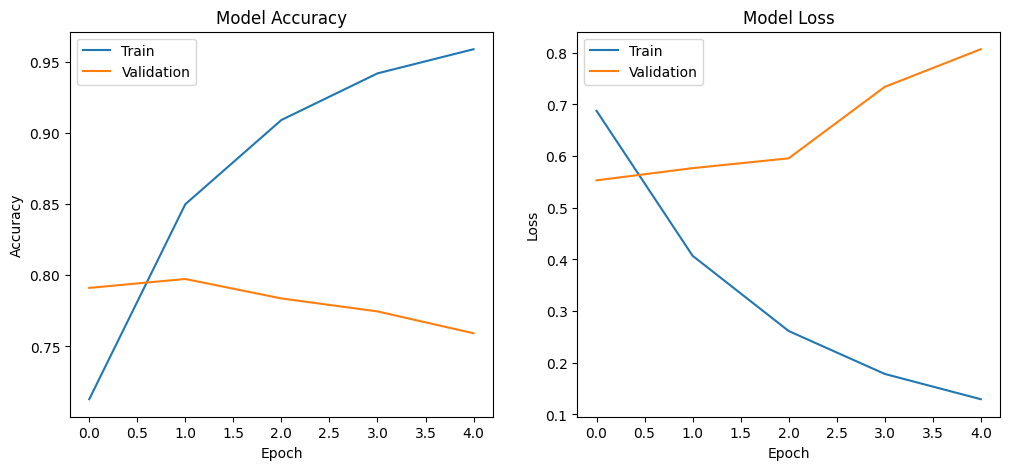

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

92/92 [==============================] - 7s 58ms/step


In [ ]:
# Evaluation using classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1889
           1       0.58      0.53      0.55       580
           2       0.62      0.78      0.69       459

    accuracy                           0.77      2928
   macro avg       0.69      0.72      0.70      2928
weighted avg       0.78      0.77      0.77      2928



In [ ]:
# Negative' corresponds to 0, 'Neutral' to 1, and 'Positive' to 2
class_names = ['Negative', 'Neutral', 'Positive']

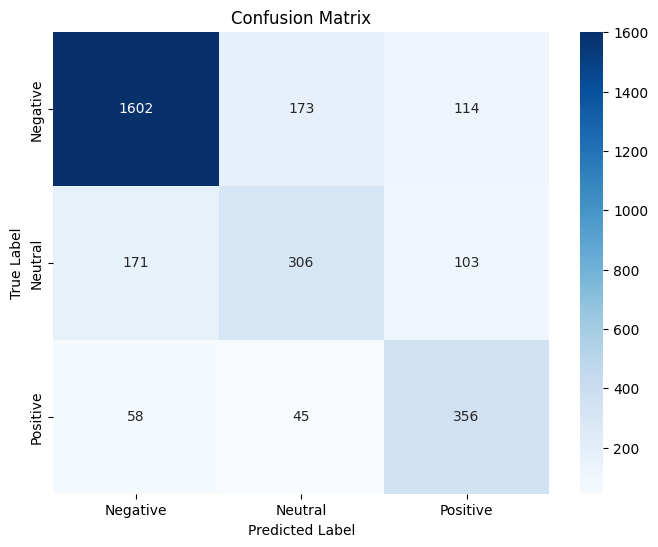

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

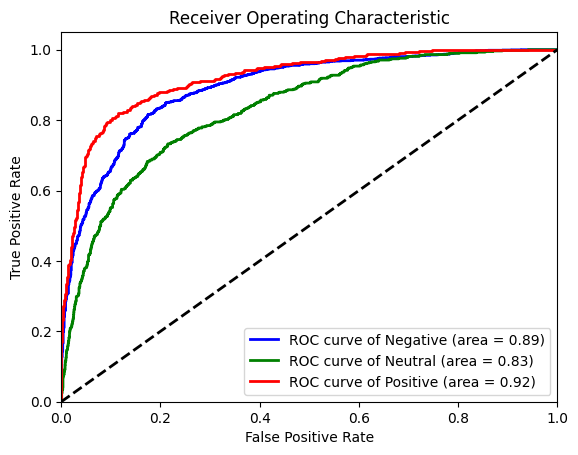

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for multi-class ROC curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
colors = cycle(['blue', 'green', 'red'])  # colors for each class
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()